In [1]:
# Set up environment with correct dependencies
using Pkg
Pkg.activate(".")
Pkg.instantiate()

 Activating environment at `~/GitHub/MathSys/teaching/MA934/MA934-slides/Project.toml`


In [2]:
using Plots
using LaTeXStrings
pyplot()
# Set default fonts for all plots
fnt = Plots.font("DejaVu Sans", 8.0)
default(titlefont=fnt, guidefont=fnt, tickfont=fnt, legendfont=fnt)

## MA934

## Floating point arithmetic

### How computers approximate arithmetic

### Representation of unsigned integers

Binary representation of (3 bit) integers:
$$ b_2b_1b_0 = b_2\,2^2 + b_1\,2^1 + b_0\,2^0 $$

Finite maximum and minimum integers.
Modern computers use 64 bits but Julia provides smaller (and larger) integer types.

Here are the unsigned integer types:



|Type |Bits |Minimum |Maximum |
|:- |--- | --- |---|
|UInt8 | 8 |0 | $2^8 - 1$|
|UInt16 | 16 |0 | $2^16 - 1$|
|UInt32 | 32 |0 | $2^{32} - 1$|
|UInt64 | 64 |0 | $2^{64} - 1$|
|UInt128 | 128 |0 | $2^{128} - 1$|

In [9]:
x=UInt8(2^8 -1)
bitstring(x)
typeof(x+1)

Int64

### Representation of signed integers : two's complement
The negative of $x>0$ is encoded using *two's complement*,

> $\overline{x}$ = flip all bits of $x$ and add 1.

Example:  
6 = 00000110,  
$\overline{6}$ = 11111001 + 1 = 11111010 

Signed integer types in Julia:

|Type |Bits |Minimum |Maximum |
|:- |--- | --- |---|
|Int8 | 8 |$-2^7$ | $2^7 - 1$|
|Int16 | 16 |$-2^{15}$ | $2^15 - 1$|
|Int32 | 32 |$-2^{31}$ | $2^{31} - 1$|
|Int64 | 64 |$-2^{63}$ | $2^{63} - 1$|
|Int128 | 128 |$-2^{127}$ | $2^{127} - 1$|

In [10]:
bitstring(Int8(-2^7))

"10000000"

### Advantages of two's complement 

Why not just use a "sign" bit?
* Avoids two representations of zero.
* Subtraction can be performed using the same hardware as addition:
> Subtraction of y from x : add  two's complement of y to x and drop leading ("overflow") bit.

* Example: $7 - 6 = 7 + \overline{6}$ =  (check) 

### Representation of real numbers

Use a binary version of *normalised* scientific notation:
$ x = -1^S \times  (1.0+0.M) \times 2^E $

e.g. IEEE 754 32-bit (Float32): 

|Field |Size|Bits |
| :-- | :-: | :-: |
| Sign (S) | 1 | 31 |
| Exponent (E + 127) | 8 | 23 - 30 |
| Mantissa (M) | 23 | 0 - 22 |

"Bias": if exponent is $E$, we store E+127 (for Float32).  This makes comparisons easier..

![Float32](files/images/590px-Float_example.png)


In [13]:
bitstring(Float32(0.15625))

"00111110001000000000000000000000"

### Round-off error

* Finite mantissae introduce errors when truncating real numbers whose binary expansion is longer than 23 (Float32) or 52 (Float64).
* Round-off error is a feature of the hardware and cannot be avoided.

In [14]:
using Printf
a = Float64(0.1); 
b = Float64(0.2); 
c = Float64(0.3);
@printf("a = %.16e, b = %.16e, c = %.16e", a, b, c);

a = 1.0000000000000001e-01, b = 2.0000000000000001e-01, c = 2.9999999999999999e-01

This can lead to counter-intuitive behaviour:

In [15]:
a + b == c

false

### Floating point arithmetic

Rules for adding two floating point numbers:

1. Rewrite the smaller number so its exponent matches that of the larger number.
2. Add the mantissae.
3. Normalise the sum.
4. Round the sum.



### Machine precision  

In [17]:
a = Float32(1.0); b = Float32(10.0^(-10));
println(a == 0.0, " ", b == 0.0, " ", a + b == a)

b*10.0^32

false false true


1.000000013351432e22

The *machine precision* (or *machine epsilon*) is the smallest floating point number which when added to 1 gives an answer larger than one.

### Machine precision

In Julia ``eps()`` gives the machine precision:

In [18]:
println(eps(Float32))
println(eps(Float64))

1.1920929e-7
2.220446049250313e-16


These values are $2.0^{-23}$ and $2.0^{-52}$, respectively.

### Loss of significance
Subtraction of "nearby" numbers leads to loss of precision.

Calculate sum and difference of 2 nearby numbers in 32-bit precision:

In [19]:
a32 = Float32(2.0) + Float32(3.0)^-12; b32 = Float32(2.0);
sum32 = a32+b32; diff32 = a32 - b32;
println("32 bit: a = ", a32, ", b = ", b32)
println("32 bit: sum = ", sum32,", difference = ", diff32 )

32 bit: a = 2.000002, b = 2.0
32 bit: sum = 4.000002, difference = 1.9073486e-6


### Loss of significance

Now calculate the same sum and difference in 64 bit precision:

In [20]:
a64 = Float64(2.0) + Float64(3.0)^-12; b64 = Float64(2.0);
sum64 = a64+b64; diff64 = a64 - b64;
println("64 bit: a = ", a64, ", b = ", b64)
println("64 bit: sum = ", sum64,", difference = ", diff64 )

64 bit: a = 2.000001881676423, b = 2.0
64 bit: sum = 4.000001881676424, difference = 1.8816764231210925e-6


### Loss of significance

We can treat the 64 bit answer as "exact" compared to the 32 bit answer and calculate the relative error in the 32 bit result:

In [21]:
relErrSum = abs(sum64-sum32)/sum64
relErrDiff = abs(diff64-diff32)/diff64
println("Sum relative error = ", relErrSum)
println("Difference relative error = ", relErrDiff)

Sum relative error = 6.41804929265656e-9
Difference relative error = 0.013643264790885564


### Numerical instability

Iterative calculations can lose precision by accumulation of round-off error:

* Assuming inputs $\sim 1$, each FP addition introduces an error of $\sim \epsilon_m$.
* Might expect, after $n$ iterative steps, total error $\sim \sqrt{n}\, \epsilon_m$?

However, some iterations can produce total error $\sim e^n$ due to *instability*.

### Numerical instability: simple example

Consider the following iterative procedures:

P1 : $a_{n+1} = \phi\,a_n$ with $a_0 = 1$,  

P2 : $a_{n+1} = a_{n-1} - a_{n}$ with $a_0 = 1$ and $a_1 = \phi$,

where $\phi = (\sqrt{5}-1)/2$.

Both have the exact solution (check): 
$$a_n = \phi^n.$$

### Numerical instability: simple example

However their numerical behaviour is very different for large $n$:

In [22]:
phi = Float32(0.5*(sqrt(5.)-1.)); n = 30
# Allocate some Float32 arrays
P1 = zeros(Float32, n); P2 = zeros(Float32, n);
# Set initial conditions
P1[1] = P2[1] = Float32(1.); P2[2] = phi;

In [23]:
for i in 2:n
    P1[i] = phi*P1[i-1]
end

In [24]:
for i in 3:n
    P2[i] = P2[i-2] - P2[i-1]
end

### Numerical instability: simple example

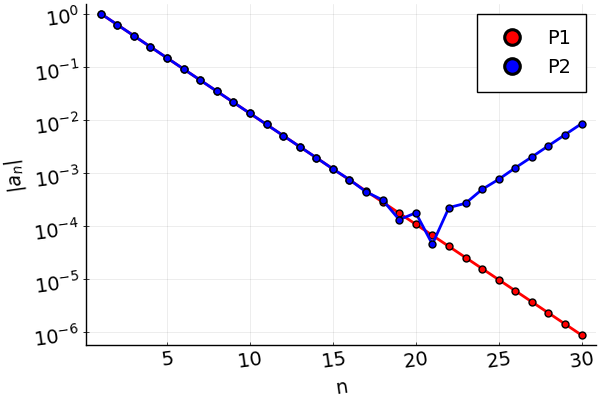

In [25]:
plot(1:n, P1, yscale=:log10, label="", linewidth=2, linecolor=:red, xlabel="n", ylabel=L"\left| a_n \right|")
scatter!(1:n, P1, markercolor=:red, label = "P1", markersize=5)
plot!(1:n, abs.(P2), label="", linewidth=2, linecolor=:blue)
scatter!(1:n, abs.(P2), markercolor=:blue, label = "P2", markersize=5)

### Numerical instability: simple example

What's going on? Due to round-off we have solved a different problem:

P2 : $a_{n+1} = a_{n-1} - a_{n}$ with $a_0 = 1$ and $a_1 = \phi + \varepsilon$.

The solution is
$$ a_n = \left(1 + \frac{\varepsilon}{\sqrt{5}}\right)\,\phi^n  - \frac{\varepsilon}{\sqrt{5}}\, \tilde{\phi}^n,$$
where $\tilde{\phi} = (-\sqrt{5}-1)/2$.  
Notice that $\left|\tilde{\phi}\right| > 1$. This is an unstable iteration.